In [1]:
import pandas as pd
import csv

import sys
sys.path.insert(0, '../')

import seaborn as sns
import matplotlib.pyplot as plt

import collections
from collections import defaultdict

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Import data, it is divided into train, test and dev set.

In [2]:
col_names=['genre', 'file', 'year', 'feature_1','feature_2', 'sentence_1', 'sentence_2', 'feature_3','feature_4']

df_train=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-train.xls', header=None, names=col_names)
df_train["sent1_length"]= df_train["sentence_1"].str.len()
df_train["sent2_length"]= df_train["sentence_2"].str.len()

df_test=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-test.xls', header=None, names=col_names)
df_test["sent1_length"]= df_test["sentence_1"].str.len()
df_test["sent2_length"]= df_test["sentence_2"].str.len()

df_dev=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-dev.xls', header=None, names=col_names)
df_dev["sent1_length"]= df_dev["sentence_1"].str.len()
df_dev["sent2_length"]= df_dev["sentence_2"].str.len()

df=pd.concat([df_train, df_test, df_dev])

In [45]:
df

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,genre,file,year,feature_1,feature_2,sentence_1,sentence_2,feature_3,feature_4,sent1_length,sent2_length
0,main-captions,MSRvid,2012test,1,5000.0,A plane is taking off.,An air plane is taking off.,NaN,NaN,22,27.0
1,main-captions,MSRvid,2012test,4,3800.0,A man is playing a large flute.,A man is playing a flute.,NaN,NaN,31,25.0
2,main-captions,MSRvid,2012test,5,3800.0,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,NaN,NaN,45,56.0
3,main-captions,MSRvid,2012test,6,2600.0,Three men are playing chess.,Two men are playing chess.,NaN,NaN,28,26.0
4,main-captions,MSRvid,2012test,9,4250.0,A man is playing the cello.,A man seated is playing the cello.,NaN,NaN,27,34.0
...,...,...,...,...,...,...,...,...,...,...,...
1495,main-news,headlines,2016,1283,2.0,Scientists prove there is water on Mars,Has Nasa discovered water on Mars?,Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),39,34.0
1496,main-news,headlines,2016,1434,0.0,Pranab stresses need to strive for peace by na...,WTO: India regrets action of developed nations,Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),51,46.0
1497,main-news,headlines,2016,1440,2.0,Volkswagen skids into red in wake of pollution...,"Volkswagen's ""gesture of goodwill"" to diesel o...",Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),54,51.0
1498,main-news,headlines,2016,1477,0.0,Obama is right: Africa deserves better leadership,Obama waiting for midterm to name attorney gen...,Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),49,50.0


### Analyze the size of each set

In [3]:
print ('The lenght of the train dataset is :', df_train.shape)
print ('The lenght of the test dataset is :', df_test.shape)
print ('The lenght of the dev dataset is :', df_dev.shape)
print ('The lenght of the total dataset is :', df.shape)

The lenght of the train dataset is : (5749, 11)
The lenght of the test dataset is : (1379, 11)
The lenght of the dev dataset is : (1500, 11)
The lenght of the total dataset is : (8628, 11)


### Groupby each different genre to understand the type of sentences.

In [52]:
df.groupby('genre').size().sort_values(ascending=False)

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


genre
main-news        4299
main-captions    3250
main-forums       629
main-forum        450
dtype: int64

In [5]:
df.groupby('genre')['sent1_length'].mean().sort_values(ascending=False)

genre
main-news        72.258897
main-forums      67.693164
main-forum       45.904444
main-captions    39.370154
Name: sent1_length, dtype: float64

In [48]:
df.groupby('file').size().sort_values(ascending=False)

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


file
headlines         2499
MSRpar            1500
MSRvid            1500
images            1500
deft-forum         450
answers-forums     375
deft-news          300
answer-answer      254
track5.en-en       250
dtype: int64

### Obtain the length of the sentences.

In [56]:
def hist_length(df):
    
    plt.figure(figsize=(10,8))
    sns.histplot(data=df, x='sent1_length', hue='file')
    plt.figure(figsize=(10,8))
    sns.histplot(data=df, x='sent2_length', hue='file')
    
    print('\n Average lenght of sentences_1 :', df["sent1_length"].mean(), '\n' )
    print('Average length of sentences_1 per genre: \n',  df.groupby('file')['sent1_length'].mean().sort_values(ascending=False), '\n')
    
    print('\n Average lenght of sentences_2 :', df["sent2_length"].mean(), '\n')
    print('Average length of sentences_2 per genre: \n',  df.groupby('genre')['sent2_length'].mean().sort_values(ascending=False))
    
    

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



 Average lenght of sentences_1 : 57.6397634371195 

Average length of sentences_1 per genre: 
 file
MSRpar        108.903000
deft-news     104.973333
headlines      46.240120
images         45.961000
deft-forum     45.904444
MSRvid         31.924000
Name: sent1_length, dtype: float64 


 Average lenght of sentences_2 : 57.38344417220861 

Average length of sentences_2 per genre: 
 file
MSRpar        109.070707
deft-news     100.772575
images         46.410000
headlines      46.192735
deft-forum     45.839729
MSRvid         31.507000
Name: sent2_length, dtype: float64


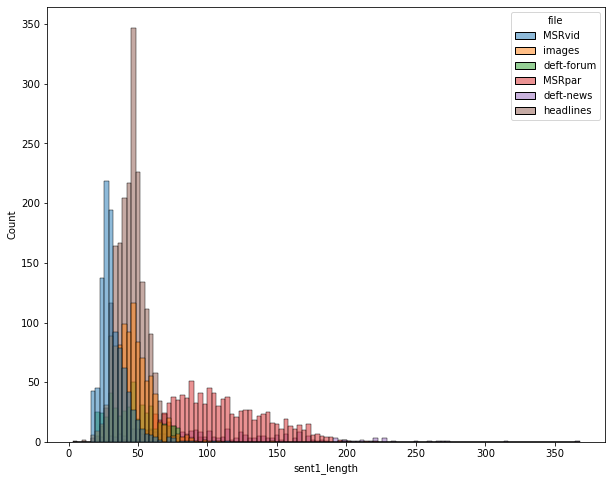

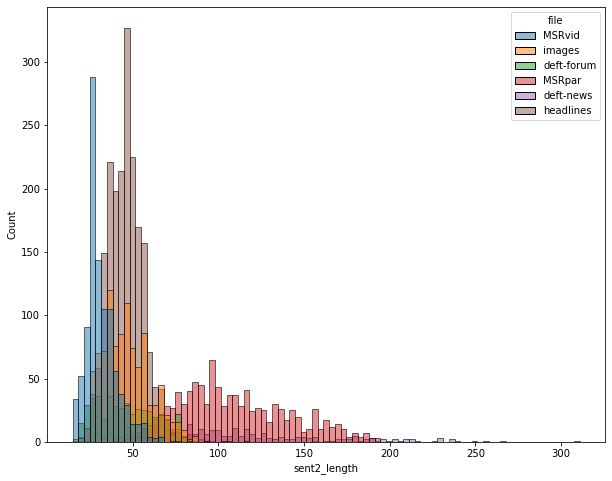

In [57]:
hist_length(df_train)

### Frequency of words and stop words

In [8]:
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
def stop_words_normal_words(df, sentence):
    corpus=[]

    sentences= df[sentence].str.split()
    words=sentences.values.tolist()
    corpus=[word for i in words for word in i]

    dict_stop_word_count=defaultdict(int)
    for word in corpus:
        if word in stop_words:
            dict_stop_word_count[word]+=1 
            
    stop_words_list=list(dict_stop_word_count.keys())
    count_stop_words_list=list(dict_stop_word_count.values())
    
    plt.figure(figsize=(25,20))         
    sns.barplot( count_stop_words_list, stop_words_list).set_title('Stop words frequency')
    
    print('The total length of our vocab is:', len(stop_words_list))
    
    ##stop_words
    counter=collections.Counter(corpus)
    most_common_words=counter.most_common()
    
    word_list=[]
    count_word_list = []
    
    for word,count in most_common_words[:150]:
        if (word not in stop_words):
            word_list.append(word)
            count_word_list.append(count)
        
    plt.figure(figsize=(20,18))        
    sns.barplot( count_word_list, word_list).set_title('Words frequency')
    
    print('The total sum of stop words is:', len(word_list))

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
df_train

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,genre,file,year,feature_1,feature_2,sentence_1,sentence_2,feature_3,feature_4,sent1_length,sent2_length
0,main-captions,MSRvid,2012test,1,5000.0,A plane is taking off.,An air plane is taking off.,NaN,NaN,22,27.0
1,main-captions,MSRvid,2012test,4,3800.0,A man is playing a large flute.,A man is playing a flute.,NaN,NaN,31,25.0
2,main-captions,MSRvid,2012test,5,3800.0,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,NaN,NaN,45,56.0
3,main-captions,MSRvid,2012test,6,2600.0,Three men are playing chess.,Two men are playing chess.,NaN,NaN,28,26.0
4,main-captions,MSRvid,2012test,9,4250.0,A man is playing the cello.,A man seated is playing the cello.,NaN,NaN,27,34.0
...,...,...,...,...,...,...,...,...,...,...,...
5744,main-news,headlines,2016,1456,0.0,Severe Gales As Storm Clodagh Hits Britain,Merkel pledges NATO solidarity with Latvia,Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),42,42.0
5745,main-news,headlines,2016,1465,0.0,Dozens of Egyptians hostages taken by Libyan t...,Egyptian boat crash death toll rises as more b...,Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),81,65.0
5746,main-news,headlines,2016,1466,0.0,President heading to Bahrain,President Xi: China to continue help to fight ...,Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),28,51.0
5747,main-news,headlines,2016,1470,0.0,"China, India vow to further bilateral ties",China Scrambles to Reassure Jittery Stock Traders,Europe Media Monitor (http://emm.newsbrief.eu),Europe Media Monitor (http://emm.newsbrief.eu),42,49.0


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


The total length of our vocab is: 131


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


The total sum of stop words is: 94


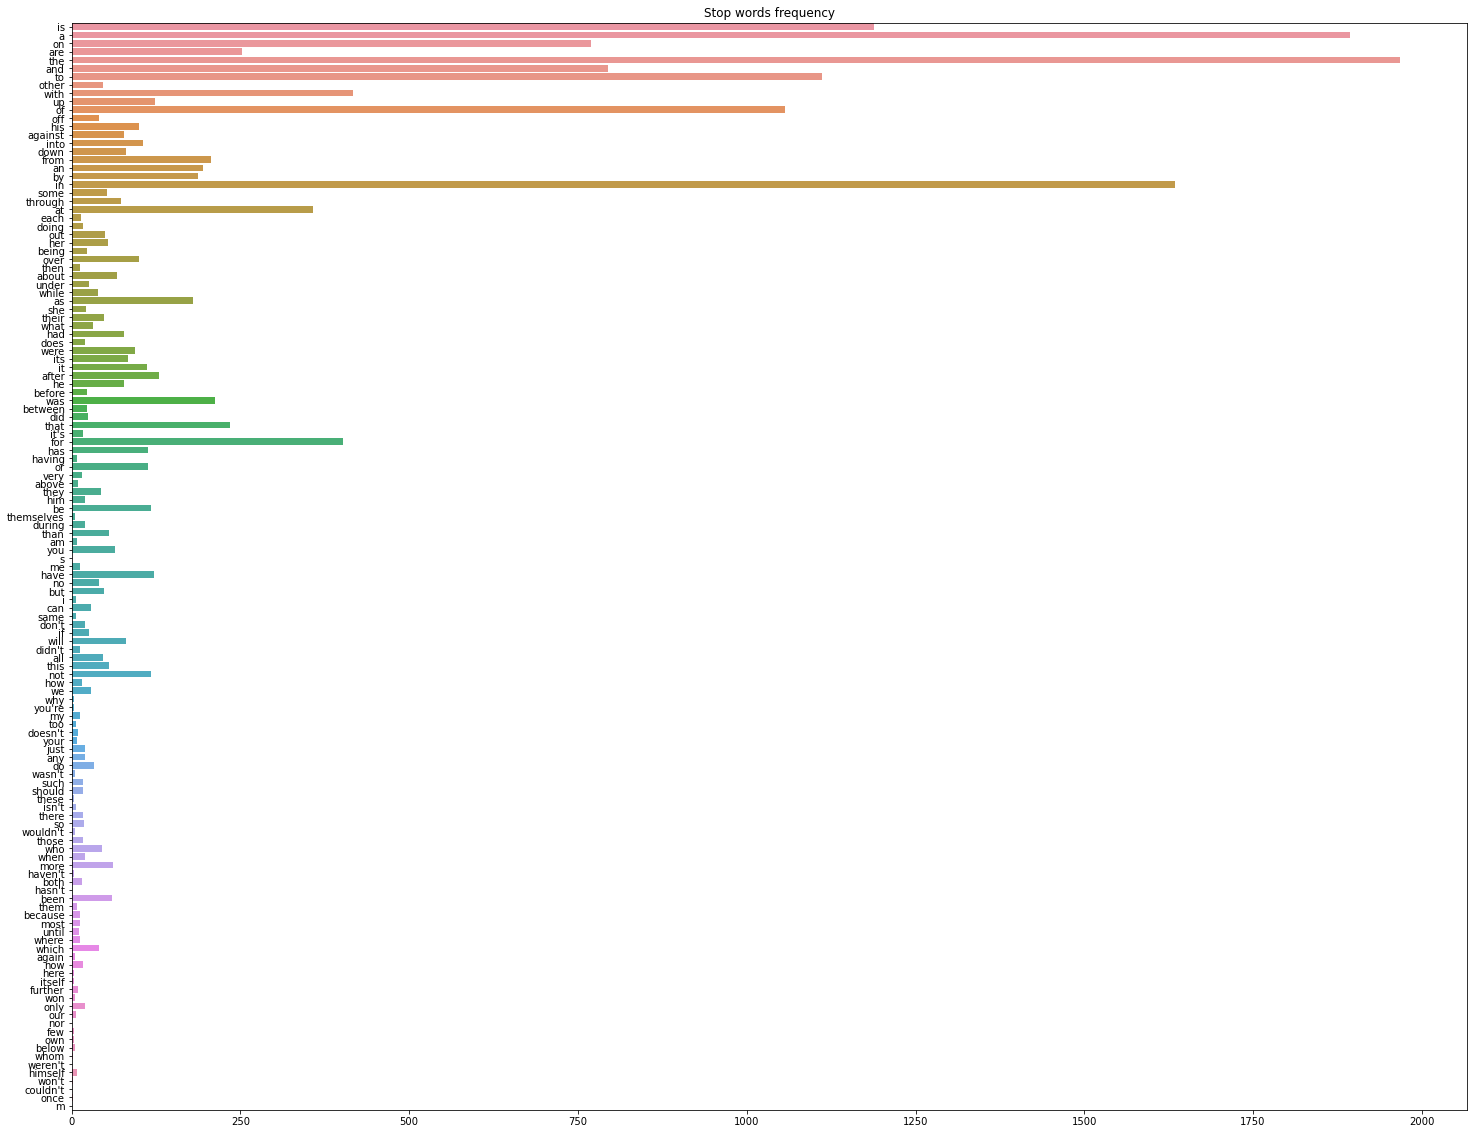

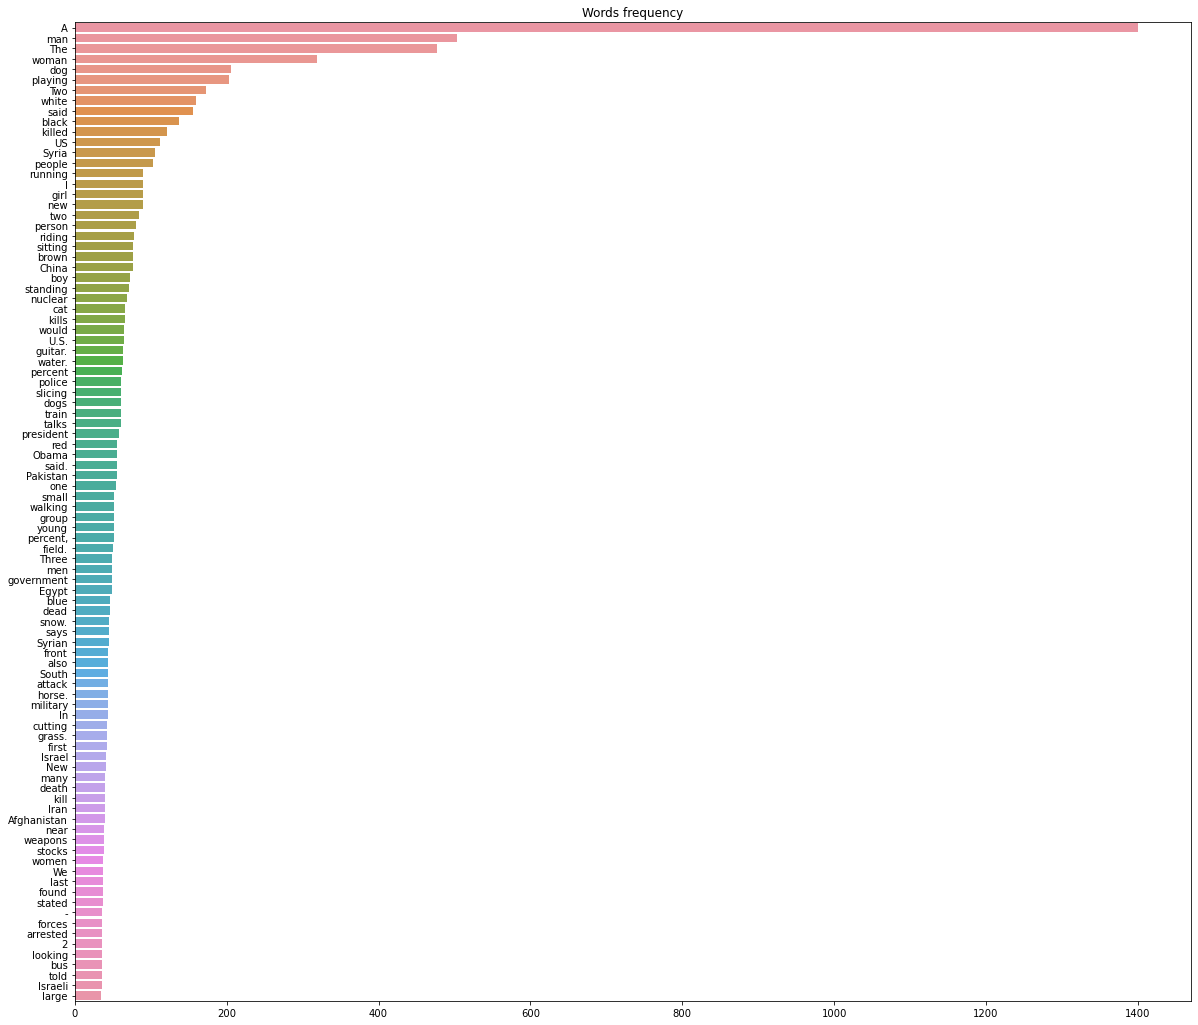

In [68]:
stop_words_normal_words(df_train, 'sentence_1')

### N-gram exploration

In [11]:
def get_top_pair_words(data, n):
    vec = CountVectorizer(ngram_range=(n, n)).fit(data)
    bag_of_words = vec.transform(data)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(20,18))  
    word,count=map(list,zip(*words_freq[0:20]))
    g=sns.barplot(count, word).set_title('Two pair words frequency')
   
    


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


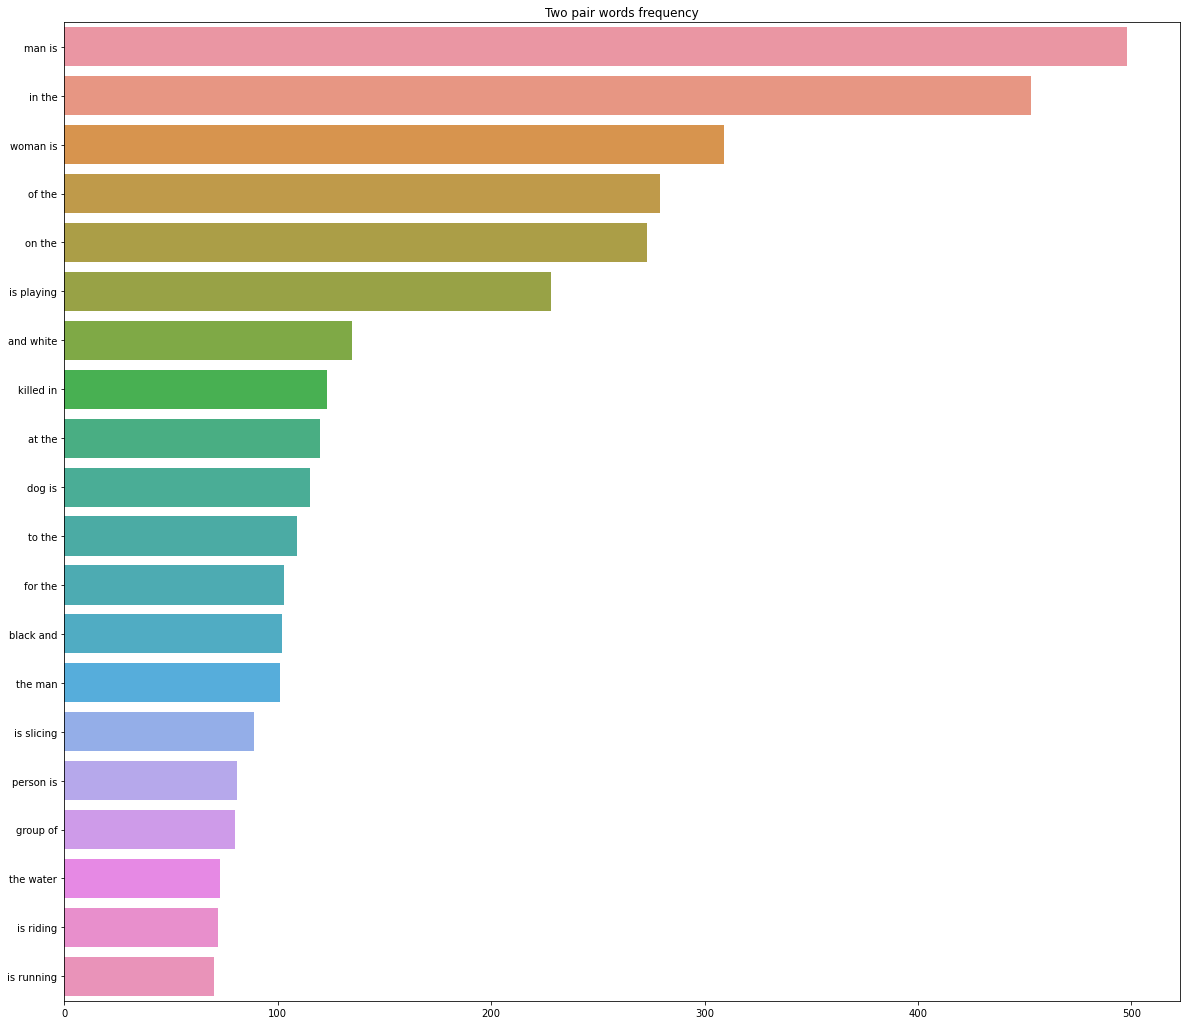

In [12]:
get_top_pair_words(df['sentence_1'], 2)


### Word cloud

In [15]:
def get_word_cloud(data):
    stop_words = nltk.corpus.stopwords.words("english")
    
    word_cloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    word_cloud=word_cloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.show()


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


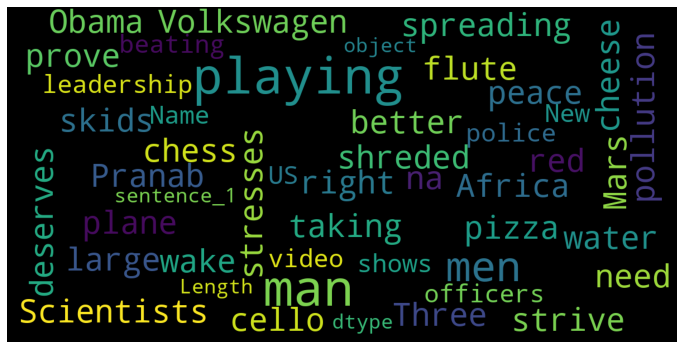

In [67]:
get_word_cloud(df['sentence_1'])

### LDA topics classification

In [17]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mariabrullmartinez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [46]:
def get_text(df, sentence):
    text=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    
    for sentence in df[sentence]:
        words=[w for w in word_tokenize(sentence) if (w not in stop_words)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        text.append(words)
        
    return text


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
text=get_text(df, 'sentence_1')


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
dict_text_gensim=gensim.corpora.Dictionary(text)
bow_corpus = [dict_text_gensim.doc2bow(list_words) for list_words in text]

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
bow_corpus

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1), (1, 1)],
 [(2, 1), (3, 1), (4, 1), (5, 1)],
 [(4, 1), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(5, 1), (10, 1), (11, 1), (12, 1)],
 [(4, 1), (5, 1), (13, 1)],
 [(12, 1), (14, 1), (15, 1)],
 [(4, 1), (16, 1)],
 [(4, 1), (5, 1), (17, 1), (18, 1)],
 [(4, 1), (5, 1), (19, 1), (20, 1)],
 [(21, 1), (22, 1), (23, 1), (24, 1)],
 [(4, 2), (17, 1), (25, 1), (26, 1)],
 [(27, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [(2, 1), (4, 1), (5, 1)],
 [(23, 1), (32, 1), (33, 1), (34, 1)],
 [(4, 1), (35, 1), (36, 1)],
 [(37, 1), (38, 1), (39, 1), (40, 1), (41, 1)],
 [(17, 1), (42, 1), (43, 1), (44, 1), (45, 1)],
 [(31, 1), (46, 1)],
 [(21, 1), (27, 1), (47, 1), (48, 1)],
 [(4, 1), (17, 1), (49, 1), (50, 1)],
 [(4, 1), (51, 1), (52, 1), (53, 1)],
 [(4, 1), (5, 1), (19, 1)],
 [(44, 1), (54, 1), (55, 1)],
 [(31, 1), (56, 1), (57, 1)],
 [(31, 1), (58, 1), (59, 1)],
 [(17, 1), (60, 1), (61, 1), (62, 1)],
 [(2, 1), (5, 1), (17, 1), (31, 1)],
 [(36, 1), (63, 1), (64, 1)],
 [(17, 1), (31, 1), (65, 1), (66, 1),

In [35]:
print(dic)

Dictionary(12782 unique tokens: ['plane', 'taking', 'flute', 'large', 'man']...)


/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dict_text_gensim,
                                   workers = 2)
lda_model.show_topics()

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.014*"The" + 0.007*"said" + 0.004*"dog" + 0.004*"percent" + 0.004*"killed" + 0.004*"say" + 0.004*"people" + 0.003*"first" + 0.003*"million" + 0.003*"n\'t"'),
 (1,
  '0.015*"The" + 0.008*"woman" + 0.008*"said" + 0.006*"man" + 0.004*"percent" + 0.003*"kill" + 0.003*"dog" + 0.003*"point" + 0.003*"Two" + 0.003*"police"'),
 (2,
  '0.013*"man" + 0.008*"The" + 0.007*"said" + 0.006*"playing" + 0.004*"woman" + 0.004*"percent" + 0.004*"Syria" + 0.003*"black" + 0.003*"two" + 0.003*"China"')]

In [70]:
pip install pyLDAvis

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note: you may need to restart the kernel to use updated packages.


In [29]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
vis = gensimvis.prepare(lda_model, bow_corpus, dict_text_gensim)
vis

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.078943 -0.033660       1        1  34.220297
0      0.068810 -0.051099       2        1  33.678962
1      0.010133  0.084760       3        1  32.100741, topic_info=           Term        Freq       Total Category  logprob  loglift
4           man  387.000000  387.000000  Default  30.0000  30.0000
5       playing  160.000000  160.000000  Default  29.0000  29.0000
19       guitar   54.000000   54.000000  Default  28.0000  28.0000
31        woman  270.000000  270.000000  Default  27.0000  27.0000
17          The  678.000000  678.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1675       year   30.940111  101.928805   Topic3  -6.3575  -0.0559
3386  Wednesday   27.774289   71.690988   Topic3  -6.4655   0.1880
1744      first   28.183890   92.255040   Topic3  -6.4508  -0.0495
1819       vote   26.667324   68.600273   Topic3  -6.5061   0.1914
316       white   27.153532  107.575256   Topic3  -6.4881  -0.2404

[300 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
3639       3  0.982458   .DJI
6653       1  0.093227   0.11
6653       3  0.839040   0.11
12350      2  0.871779    1.5
12424      3  0.948211   1.91
...      ...       ...    ...
1752       2  0.293958  would
1752       3  0.385186  would
1675       1  0.255080   year
1675       2  0.441485   year
1675       3  0.304134   year

[526 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])